<a href="https://colab.research.google.com/github/yuja28/sw_Bootcamp/blob/main/bottle_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# 데이터셋 경로 설정
train_data_dir = '/content/drive/MyDrive/mvtecv/bottle/test'
test_data_dir = '/content/drive/MyDrive/mvtecv/bottle/train'

# 이미지 리사이징을 위한 크기 설정
image_height, image_width = 224, 224


# 데이터셋 전처리를 위한 ImageDataGenerator 설정
train_datagen = ImageDataGenerator(rescale=1./255)  # 훈련 데이터 정규화
test_datagen = ImageDataGenerator(rescale=1./255)   # 테스트 데이터 정규화


# 테스트 데이터의 'good' 카테고리 경로 설정
test_good_data_dir = os.path.join(test_data_dir, 'good')

# 테스트 데이터의 'good' 카테고리 이미지 로드
test_good_images = [os.path.join(test_good_data_dir, img) for img in os.listdir(test_good_data_dir)]

# 테스트 데이터의 'good' 카테고리 레이블 지정
test_good_labels = np.zeros(len(test_good_images))  # 정상 병태의 레이블은 0으로 지정



In [3]:
# 훈련 데이터의 이상 카테고리 이미지 로드 (broken_small + contamination)
train_anomaly_data_dirs = [os.path.join(train_data_dir, 'broken_small'), os.path.join(train_data_dir, 'contamination')]
train_anomaly_images = []
for anomaly_data_dir in train_anomaly_data_dirs:
    anomaly_images = [os.path.join(anomaly_data_dir, img) for img in os.listdir(anomaly_data_dir)]
    train_anomaly_images.extend(anomaly_images)

# 훈련 데이터의 이상 카테고리 레이블 지정 (이상은 1로 지정)
train_anomaly_labels = np.ones(len(train_anomaly_images))

# 훈련 데이터의 'good' 카테고리 경로 설정
train_good_data_dir = os.path.join(train_data_dir, 'good')

# 훈련 데이터의 'good' 카테고리 이미지 로드
train_good_images = [os.path.join(train_good_data_dir, img) for img in os.listdir(train_good_data_dir)]

# 훈련 데이터의 'good' 카테고리 레이블 지정
train_good_labels = np.zeros(len(train_good_images))  # 정상 병태의 레이블은 0으로 지정

In [4]:
# 훈련 데이터와 테스트 데이터의 이상 카테고리 이미지 및 레이블을 합쳐서 최종 데이터 생성
train_images = train_good_images + train_anomaly_images
train_labels = np.concatenate([train_good_labels, train_anomaly_labels])

test_images = test_good_images
test_labels = test_good_labels


# 데이터를 배열로 변환
train_images = np.array(train_images)
test_images = np.array(test_images)

# 데이터를 배열로 변환
train_images = np.array(train_images)
test_images = np.array(test_images)

# 데이터 전처리를 위해 데이터셋 생성
#학습데이터
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=32,
    class_mode='binary'
)
#검증데이터
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(image_height, image_width),
    batch_size=32,
    class_mode='binary'
)

Found 83 images belonging to 4 classes.
Found 209 images belonging to 1 classes.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout
from tensorflow.keras.models import Model

# ResNet-50 모델 가져오기 (이미 학습된 가중치를 포함)
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Fully Connected Layers 추가하기
x = GlobalAveragePooling2D()(resnet.output)
output_layer = Dense(1, activation='sigmoid')(x)
x=Dropout(0.5)(x)
# 모델 정의
model = Model(inputs=resnet.input, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 모델 학습
history = model.fit(
    train_generator,
    batch_size = 32,
    epochs = 10,
    validation_data=test_generator,
  validation_steps=len(test_generator)
)
model.save('bottle.h5')

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
3/3 [==============================] - 81s 9s/step - loss: -6.2972 - accuracy: 0.3253 - val_loss: 0.1056 - val_accuracy: 1.0000
Epoch 2/10
3/3 [==============================] - 13s 6s/step - loss: -35.2660 - accuracy: 0.3976 - val_loss: 15475.4092 - val_accuracy: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 13s 6s/step - loss: -54.7085 - accuracy: 0.3373 - val_loss: 687.2818 - val_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 13s 6s/step - loss: -71.3608 - accuracy: 0.3614 - val_loss: 362645.8125 - val_accuracy: 0.0000e+00
Epoch 5/10
3/3 [==============================] - 10s 4s/step - loss: -87.9512 - accuracy: 0.3735 - val_loss: 120754.4844 - val_accuracy: 0.0000e+00
Epoch 6/10
3/3 [==============================] - 9s 4s/step - loss: -110.1326 - accuracy: 0.2892 - val_loss: 137864.1875 - val_accuracy: 0.0000e+00
Epoch 7/10
3/3 [==============================] - 11s 5

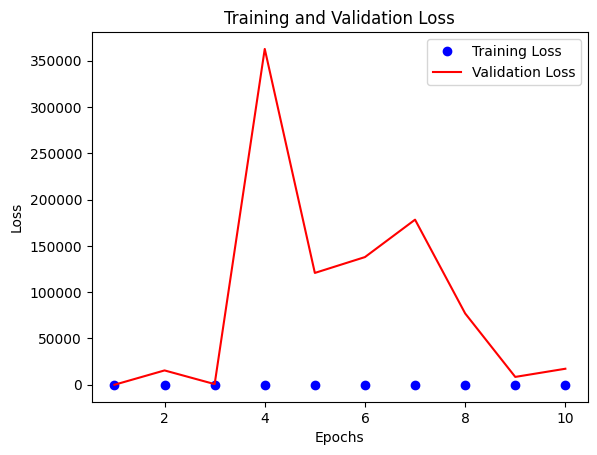

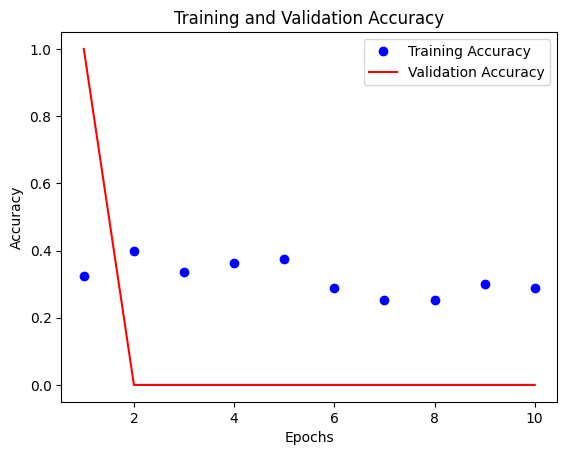

In [6]:
import matplotlib.pyplot as plt
# 학습 과정에서의 손실값과 정확도 변화 추출
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 에포크 수
epochs = range(1, len(train_loss) + 1)

# 손실값 그래프
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.figure()
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
